# Shapley Additive Expllanations

### O que é?

Shapley Additive Expllanations (SHAP) é um método proposto por Lundberg e Leen em 2017 [1] para interpretação das previsões de modelos de Machine Learning (ML) por meio de valores Shapley [2]. O ponto principal é calcular os valores de Shapley para cada feature dada uma amostra e cada valor de Shapley obtido representa o impacto daquela feature para a predição do modelo.



### Exemplo de cálculo de valores Shapley

Vamos primeiro criar um jogo cooperativo. Três amigos - Ram, Abhiraj e Pranav - saem para uma refeição juntos. Eles pedem e compartilham batatas fritas, vinho e torta. É difícil determinar quanto cada um deve pagar, pois eles não comeram uma quantidade igual. Portanto, temos as seguintes informações:

- Se Ram comer sozinho, ele pagaria 800.
- Se Abhiraj comer sozinho, ele pagaria 560.
- Se Pranav comer sozinho, ele pagaria 700.
- Se Ram e Abhiraj comerem sozinhos, eles pagariam 800.
- Se Ram e Pranav comerem sozinhos, eles pagariam 850.
- Se Abhiraj e Pranav comerem sozinhos, eles pagariam 720.
- Se Ram, Abhiraj e Pranav comerem juntos, eles pagariam 900.


Agora, o objetivo é descobrir quanto cada um deles deve pagar individualmente quando comem juntos. O método que vamos adotar aqui é o seguinte: Consideramos todas as permutações dos 3 participantes em sequência e observamos o pagamento incremental que cada um deles deve fazer.

A sequência aqui é Ram, Abhiraj e depois Pranav, sucessivamente. Como descrito acima, Ram chega primeiro e paga 800. Agora, Ram e Abhiraj pagam juntos 800, então não há pagamento adicional para Abhiraj. Logo, o valor é 0. E finalmente, todos os 3 comem juntos e pagam 900, então o pagamento adicional para Pranav é 100. Repetimos o mesmo exercício para cada ordem possível dos 3 amigos e obtemos os seguintes valores marginais de pagamento:

- (Ram, Abhiraj, Pranav) - (800, 0, 100)
- (Abhiraj, Ram, Pranav) - (560, 240, 100)
- (Abhiraj, Pranav, Ram) - (560, 160, 180)
- (Pranav, Ram, Abhiraj) - (700, 150, 50)
- (Pranav, Abhiraj, Ram) - (700, 20, 180)
- (Ram, Pranav, Abhiraj) - (800, 50, 50)

Então, qual é o valor de Shapley para Ram, Abhiraj e Pranav, respectivamente? É apenas a média do pagamento marginal para cada um! Por exemplo, para Ram é (800 + 240 + 180 + 150 + 180 + 800) / 6 = 392. Da mesma forma, para Abhiraj é 207 e para Pranav é 303. O total é 900.

Exemplo retirado de [3].

### Paralelo com ML/DL

Para entender como isso se aplica em Machine e Deep Learning basta imaginar que cada amigo é uma feature do nosso conjunto de dados. Observe o dataset a seguir:

| Tamanho (metros quadrados) | Número de Quartos | Preço de Venda (em milhares de dólares) |
|---------------------------|-------------------|----------------------------------------|
| 150                       | 3                 | 250                                    |
| 200                       | 4                 | 350                                    |
| 120                       | 2                 | 180                                    |
| ...                       | ...               | ...                                    |


Para calcular os valores Shapley para a feature "Número de Quartos" em relação a uma casa que possui 150 metros quadrados e 3 quartos, siga os passos abaixo:

1. Primeiro, calcule a predição do modelo utilizando o valor "Número de Quartos" igual a 3.

2. Em seguida, calcule a predição do modelo sem considerar a feature "Número de Quartos". Isso pode ser feito desativando completamente essa feature ou substituindo-a pelo valor médio presente no conjunto de dados.

3. Calcule a diferença entre os valores obtidos nos passos anteriores. Essa diferença representa o impacto específico da feature "Número de Quartos" na predição do modelo para essa casa em particular.

4. Repita esse processo para todos os valores possíveis de "Número de Quartos" para a casa em questão. Em seguida, calcule a média das diferenças obtidas, e esse será o valor de Shapley para a feature "Número de Quartos".


## SHAP em Visão Computacional (Prático)

### Instalação

In [ ]:
!pip install shap
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib

### Imports

In [ ]:
import shap
import json
import random

import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from typing import Any, Union

### ResNet50 pré-treinada no conjunto ImageNet

In [2]:
model = ResNet50(weights= 'imagenet')

def make_inference(input_image: Union[np.ndarray, list]) -> Any:
    """Make inference using the ResNet50 model.

    Args:
        model (Any): The pre-trained ResNet50 model.
        input_image (Union[np.ndarray, list]): The input image as a NumPy array or a list.

    Returns:
        Any: The model's prediction for the input image.
    """
    if isinstance(input_image, list):
        input_image = np.array(input_image)
        
    input_image_copy = input_image.copy()
    preprocessed_input = preprocess_input(input_image_copy)
    return model(preprocessed_input)


### Carregar exemplo aleatório do dataset

In [3]:
X, y = shap.datasets.imagenet50()
sample = X[random.randint(0, 50)]
sample = np.expand_dims(sample, axis=0)

### Carregar labels do conjunto ImageNet e criar mapeamento entre ids e nomes

In [4]:
labels_url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

with open(shap.datasets.cache(labels_url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

In [5]:
class_names[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

### Máscara de inpaint

Como no SHAP é necessário "desativar" algumas features, no caso de imagens, podemos apagar um superpixel e completar ele utilizando inpaint [4].

In [6]:
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

### Explicação visual com Partition Explainer

Esse método de cálculo dos valores de Shapley organiza as features de uma maneira hierárquica, onde grupos de features relacionadas são agrupadas. Para cada grupo é atribuido um crédito de forma recursiva, ele começa com o grupo de todas as características e as divide em subgrupos menores. Em seguida, calcula um cŕedito para cada subgrupo com base na diferença das previsões quando esse subgrupo está presente ou não.

In [11]:
explainer = shap.Explainer(make_inference, masker, output_names=class_names)
shap_values = explainer(sample, max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:10])

Partition explainer: 2it [00:47, 47.24s/it]               


Para definir os super pixels da imagem a biblioteca utiliza uma estratégia chamada "herarchical clustering based on axis-aligned splits".

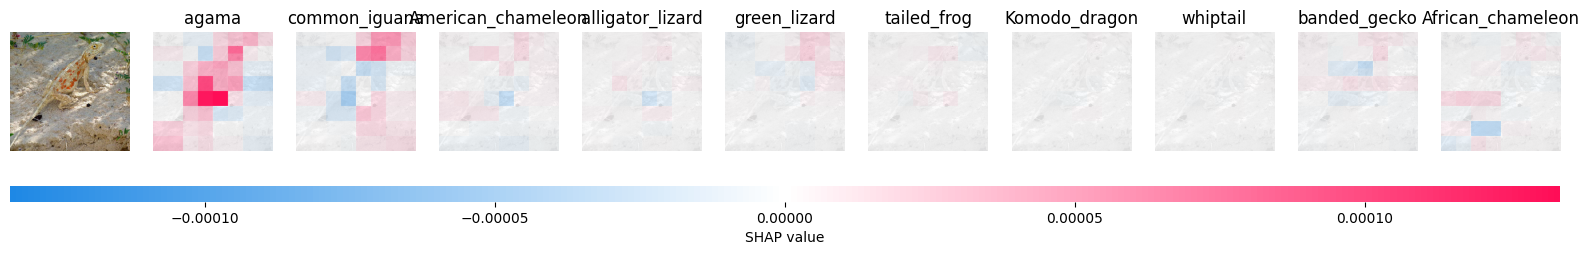

In [12]:
shap_values.data = np.array(shap_values.data, np.int32)
shap.image_plot(shap_values)

# Referências

[1] https://arxiv.org/pdf/1705.07874.pdf

[2] https://www.degruyter.com/document/doi/10.1515/9781400881970-018/html

[3] https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/

[4] https://docs.opencv.org/3.4/df/d3d/tutorial_py_inpainting.html